In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
data = pd.read_csv('data/cheap_train_sample.csv')
data.shape

(6513, 14)

In [100]:
test_data = pd.read_csv('data/test_data.csv')
test_data.shape

(16281, 13)

# 1) Pre-process data

Concatenate train and test data so that that two are pre-processed the same way. 

In [101]:
concat_train_test = pd.concat([data,test_data])

## 1.1) Binarize Target Feature

In [102]:
# the .replace method below does not change the vaues from the test set (NaNs)
concat_train_test['wage'] = concat_train_test['wage'].replace({' <=50K':0, ' >50K':1})

In [103]:
concat_train_test['wage'].unique()

array([ 0.,  1., nan])

## 1.2) Resolve 'never_worked' with 'hours_per_week'

For all rows with `work-class` in  [ 'never worked' ,'without pay'],  set `hours_per_week` to 0.


In [104]:
# create a filter disjunction
filter1 = (concat_train_test['workclass']==' Without-pay')
filter2 = (concat_train_test['workclass']==' Never-worked'  )
filter_disjunction = filter1 | filter2

In [105]:
concat_train_test.loc[filter_disjunction,['hours-per-week']] = 0

In [106]:
concat_train_test.loc[filter_disjunction,['hours-per-week']]

,hours-per-week
2019,0
4124,0
4167,0
5944,0
2957,0
3177,0
6466,0
8785,0
8903,0
10647,0


## 1.3) Dummy Features

In [107]:
dumb_feats = ['workclass','marital-status','occupation','sex']
concat_train_test = pd.get_dummies(concat_train_test, 
               columns = dumb_feats, 
               drop_first=True
              )

In [108]:
#view the new feature columns
concat_train_test.head().T


,0,1,2,3,4
age,56,28,33,26,40
fnlwgt,346033,96226,251120,178140,56795
education,9th,HS-grad,Bachelors,Bachelors,Masters
education-num,5,9,13,13,14
relationship,Not-in-family,Husband,Husband,Husband,Not-in-family
capital-gain,0,0,7688,0,14084
capital-loss,0,0,0,0,0
hours-per-week,40,45,50,45,55
native-country,United-States,United-States,United-States,United-States,United-States
wage,0.0,0.0,1.0,1.0,1.0


## 1.4) Drop Features

In [109]:
drop_feats = ['fnlwgt', 'education',
              'relationship', #'capital-gain','capital-loss',
              'native-country',
             ]

concat_train_test.drop(columns=drop_feats, inplace = True)

# 2) Re-Split train and test data

In [110]:
data = concat_train_test.iloc[:len(data),:] #dummied, dropped
test_data = concat_train_test.iloc[len(data):] # dummied, dropped

# 3) Data Imbalance
We will upsample the >50k group to deal with the fact that 76% of the data points are for the <=50k group. 

In [111]:
# examine class balance
data['wage'].value_counts() 

0.0    4945
1.0    1568
Name: wage, dtype: int64

In [112]:
data['wage'].value_counts(normalize=True)

0.0    0.759251
1.0    0.240749
Name: wage, dtype: float64

In [113]:
from sklearn.utils import resample

# rows with wage = 0 (76%)
under_50k = data[ data['wage'] == 0]

#rows with wage =1 (24%)
over_50k = data[data['wage'] == 1]

#augment B to have the same number of rows as A
over_50k_aug = resample(over_50k, 
                replace = True,
                n_samples = len(under_50k),
                 random_state = 14
                )

data_balanced = pd.concat([under_50k,over_50k_aug] )
data_balanced['wage'].value_counts()

0.0    4945
1.0    4945
Name: wage, dtype: int64

# 4) Split X & Y  (source & target)

In [114]:
X = data_balanced.drop(columns = ['wage'])
y = data_balanced['wage']

For the test data, there isno target. 

In [115]:
X_test = test_data.drop(columns = ['wage'])
# y_test will be predicted below and assesed by judges.

In [116]:
from sklearn.model_selection import train_test_split

X_train,X_val,y_train,y_val = train_test_split(X,y,random_state=8,shuffle=True ,stratify=y)

# 5) Models to stack

**Plan**: Grid search for each model type, then stack.


In [117]:
import time 
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

### Logistic Regression

In [119]:
%%time
from sklearn.linear_model import LogisticRegression

pipe_logreg = Pipeline([
    ('ss',StandardScaler()),
    ('logreg',LogisticRegression(penalty='l2' , max_iter=10**5) )
     ])

grid_logreg = {
    'logreg__penalty': ['l2','none'],
}
gs_logreg = GridSearchCV(pipe_logreg, 
                         param_grid= grid_logreg,
                        )

gs_logreg.fit(X_train,y_train)

print(f'Train score: {gs_logreg.score(X_train,y_train)}')
print(f'Test score: {gs_logreg.score(X_val,y_val)}')
gs_logreg.best_score_, gs_logreg.best_params_ 

Train score: 0.8120533908588378
Test score: 0.8111605337646584
CPU times: user 1.46 s, sys: 421 ms, total: 1.88 s
Wall time: 304 ms


(0.8073380613711916, {'logreg__penalty': 'l2'})

In [80]:
# pipe_logreg.get_params()


### kNN

In [120]:
%%time
from sklearn.neighbors import KNeighborsClassifier

pipe_knn = Pipeline([
    ('ss',StandardScaler()),
    ('knn' , KNeighborsClassifier(n_neighbors=10,weights='uniform') )
])

grid_knn = {'knn__n_neighbors':[8,9,10,11,12],
            'knn__weights': ['uniform','distance']
           }

gs_knn =GridSearchCV(pipe_knn,
                    param_grid=grid_knn)

gs_knn.fit(X_train, y_train)
print(f'Train score: {gs_knn.score(X_train,y_train)}')
print(f'Test score: {gs_knn.score(X_val,y_val)}')

gs_knn.best_score_ , gs_knn.best_params_

Train score: 0.9897532695159769
Test score: 0.8811160533764658
CPU times: user 49.2 s, sys: 10.9 s, total: 1min
Wall time: 8.72 s


(0.8682759504392095, {'knn__n_neighbors': 8, 'knn__weights': 'distance'})

### Decision Tree

In [122]:
%%time

from sklearn.tree import DecisionTreeClassifier


pipe_dtc = Pipeline([
    ('ss',StandardScaler()),
    ('dtc',DecisionTreeClassifier(max_depth=5,min_samples_split=5) )
     ])

grid_dtc = {
    'dtc__max_depth': [None,1,5,10,15], 
    'dtc__min_samples_split': [5,6,7,8],
}
gs_dtc = GridSearchCV(pipe_dtc, 
                         param_grid= grid_dtc,
                        )
gs_dtc.fit(X_train,y_train)
print(f'Train score: {gs_dtc.score(X_train,y_train)}')
print(f'Test score: {gs_dtc.score(X_val,y_val)}')

gs_dtc.best_score_, gs_dtc.best_params_


Train score: 0.9730349197788863
Test score: 0.8993125758188435
CPU times: user 1.29 s, sys: 6.88 ms, total: 1.29 s
Wall time: 1.29 s


(0.863557606149115, {'dtc__max_depth': None, 'dtc__min_samples_split': 5})

In [123]:
# pipe_dtc.get_params()

### Bagging Trees

In [124]:
%%time

from sklearn.ensemble import BaggingClassifier

pipe_btc = Pipeline([
    ('ss',StandardScaler()),
    ('btc',BaggingClassifier(n_estimators=150) )
     ])

grid_btc = {
    'btc__n_estimators': [150],
#     'btc__max_depth': [None,1,5,10,15], 
#     'btc__min_samples_split': [5,6,7,8],
}
gs_btc = GridSearchCV(pipe_btc, 
                         param_grid= grid_btc,
                        )
gs_btc.fit(X_train,y_train)
print(f'Train score: {gs_btc.score(X_train,y_train)}')
print(f'Test score: {gs_btc.score(X_val,y_val)}')

gs_btc.best_score_, gs_btc.best_params_

Train score: 0.9897532695159769
Test score: 0.9158916295996765
CPU times: user 8.73 s, sys: 47.6 ms, total: 8.78 s
Wall time: 8.78 s


(0.8920056234812147, {'btc__n_estimators': 150})

In [125]:
# pipe_btc.get_params()

### Random Forest

In [126]:
%%time
from sklearn.ensemble import RandomForestClassifier
# rfc = RandomForestClassifier()

pipe_rfc = Pipeline([
    ('ss',StandardScaler()),
    ('rfc',RandomForestClassifier(max_depth=10, n_estimators=200) )
     ])

grid_rfc = {
    'rfc__n_estimators': [100,150,200],
    'rfc__max_depth': [6,8,10,12,14,16],
}
gs_rfc = GridSearchCV(pipe_rfc, 
                         param_grid= grid_rfc,
                        )
gs_rfc.fit(X_train,y_train)
print(f'Train score: {gs_rfc.score(X_train,y_train)}')
print(f'Test score: {gs_rfc.score(X_val,y_val)}')

gs_rfc.best_score_, gs_rfc.best_params_ #cvs.832 {'rfc__max_depth': 10, 'rfc__n_estimators': 200})


Train score: 0.937845490090333
Test score: 0.8920339668418924
CPU times: user 31.2 s, sys: 148 ms, total: 31.4 s
Wall time: 31.4 s


(0.8872868248051138, {'rfc__max_depth': 16, 'rfc__n_estimators': 150})

In [127]:
# pipe_rfc.get_params()

### AdaBoost Logreg

In [128]:
%%time
from sklearn.ensemble import AdaBoostClassifier
ada_logreg = AdaBoostClassifier(base_estimator=LogisticRegression())

pipe_ada_logreg = Pipeline([
    ('ss',StandardScaler()),
    ('ada_logreg', AdaBoostClassifier(base_estimator=LogisticRegression(),
                                      learning_rate=1.1,n_estimators = 10),
    )
     ])

grid_ada_logreg = {
'ada_logreg__learning_rate': [0.9,1.0,1.1],
 'ada_logreg__n_estimators': [10,50,100],
}
gs_ada_logreg = GridSearchCV(pipe_ada_logreg, 
                         param_grid= grid_ada_logreg,
                        )
gs_ada_logreg.fit(X_train,y_train)
print(f'Train score: {gs_ada_logreg.score(X_train,y_train)}')
print(f'Test score: {gs_ada_logreg.score(X_val,y_val)}')

gs_ada_logreg.best_score_, gs_ada_logreg.best_params_ # 0.8296472557343492

Train score: 0.805446946204665
Test score: 0.8091386979377274
CPU times: user 1min 9s, sys: 16.2 s, total: 1min 25s
Wall time: 11.8 s


(0.8047756878040978,
 {'ada_logreg__learning_rate': 0.9, 'ada_logreg__n_estimators': 100})

In [129]:
# pipe_ada_logreg.get_params()

### AdaBoost Decision Tree

In [130]:
%%time
from sklearn.ensemble import AdaBoostClassifier
# ada_tree = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
pipe_ada_tree = Pipeline([
    ('ss',StandardScaler()),
    ('ada_tree', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),learning_rate =0.9,n_estimators=100) )
     ])

grid_ada_tree = {
'ada_tree__learning_rate': [0.9,1.0,1.1],
 'ada_tree__n_estimators': [10,50,100],
}
gs_ada_tree = GridSearchCV(pipe_ada_tree, 
                         param_grid= grid_ada_tree,
                        )
gs_ada_tree.fit(X_train,y_train)
print(f'Train score: {gs_ada_tree.score(X_train,y_train)}')
print(f'Test score: {gs_ada_tree.score(X_val,y_val)}')

gs_ada_tree.best_score_, gs_ada_tree.best_params_


Train score: 0.9897532695159769
Test score: 0.921552769915083
CPU times: user 20.9 s, sys: 52.9 ms, total: 21 s
Wall time: 21 s


(0.897937814548713,
 {'ada_tree__learning_rate': 1.0, 'ada_tree__n_estimators': 50})

# 6) Stack the best model from each model class

In [131]:
from sklearn.ensemble import StackingClassifier

In [132]:
level1_models = [
#     ('pipe_logreg', Pipeline([
#             ('ss',StandardScaler()),
#             ('logreg',LogisticRegression(penalty='l2' , max_iter=10**5) )])
#             ), #end pipe_logreg
    ('pipe_knn', Pipeline([
        ('ss',StandardScaler()),
        ('knn' , KNeighborsClassifier(n_neighbors=10,weights='uniform') )] )
            ), # end pipe_knn
    ('pipe_dtc' , Pipeline([
        ('ss',StandardScaler()),
        ('dtc',DecisionTreeClassifier(max_depth=5) )])
            ), # end pipe_dtc
    ('pipe_btc',Pipeline([
        ('ss',StandardScaler()),
        ('btc',BaggingClassifier(n_estimators=150) )
         ])
            ), #end bag
    ('pipe_rfc', Pipeline([
        ('ss',StandardScaler()),
        ('rfc',RandomForestClassifier(max_depth=10, n_estimators=200) )
         ])
            ), # end rfc 
#     ('pipe_ada_logreg' , Pipeline([
#         ('ss',StandardScaler()),
#         ('ada_logreg', AdaBoostClassifier(base_estimator=LogisticRegression(),
#                                             learning_rate=1.1, n_estimators = 10))
#          ])
#         ), #end adalog
    ('pipe_ada_tree' , Pipeline([
        ('ss',StandardScaler()),
        ('ada_tree', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),learning_rate =0.9,n_estimators=100) )
         ]) #end adatree
)
                ]
     

stack = StackingClassifier(estimators=level1_models,
                         final_estimator=LogisticRegression())

In [133]:
%%time
cross_val_score(stack,X_train, y_train).mean() #0.9010390899193557

CPU times: user 1min 31s, sys: 5.98 s, total: 1min 37s
Wall time: 1min 13s


0.9013086316983314

In [134]:
%%time
stack.fit(X_train,y_train)

stack.score(X_train,y_train), gs_rfc.score(X_train,y_train)

CPU times: user 23.4 s, sys: 2.14 s, total: 25.5 s
Wall time: 18.5 s


(0.9886746663071323, 0.937845490090333)

In [135]:
stack.score(X_val,y_val),gs_rfc.score(X_val,y_val)

(0.9276182773958754, 0.8920339668418924)

In [81]:
#sub_d = test_data.drop(columns=['wage'])

In [137]:
# X_test = test_data.drop(columns=['wage']) above
preds = stack.predict(X_test)
probs = stack.predict_proba(X_test)

In [140]:
# checking index of test dataset was retained before creating a data frame 
test_data.index[:5], test_data.index[-5:]

(Int64Index([0, 1, 2, 3, 4], dtype='int64'),
 Int64Index([16276, 16277, 16278, 16279, 16280], dtype='int64'))

In [156]:
submission = pd.DataFrame(
                index = test_data.index, # index from test data
                columns=['preds','wage'] #required column names 
                         )
submission['preds'] = preds.astype(int)
submission['wage'] = probs

submission.head()

,preds,wage
0,0,0.992403
1,0,0.937127
2,0,0.719230
3,1,0.094925
4,0,0.992675


In [153]:
submission.to_csv(path_or_buf='sub.csv', index=False)

# 7) Metrics

## 7.1) F1 score

This competition will be judge on F1 scores. Thus, we examine

In [157]:
from sklearn.metrics import f1_score

In [161]:
f1_score(y_val,stack.predict(X_val)) 

0.9299412915851272

# Confusion Matrix 

/Users/wonderman/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


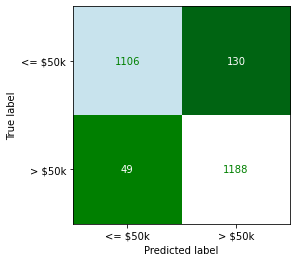

In [160]:
from sklearn.metrics import plot_confusion_matrix 

plot_confusion_matrix(stack, X_val,y_val, cmap='ocean', 
                      display_labels=['<= $50k','> $50k'],
                     colorbar=False); 

/Users/wonderman/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


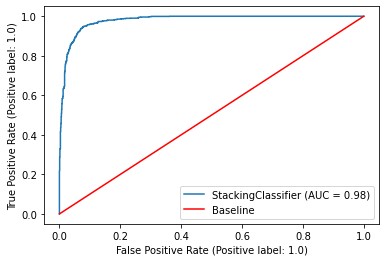

In [162]:
from sklearn import metrics
metrics.plot_roc_curve(stack, X_val,y_val)
plt.plot([0,1],[0,1], color='r', label='Baseline')
# add a legend
plt.legend();

In [163]:
probs = stack.predict_proba(X_val)[:,1]
metrics.roc_auc_score(y_val,probs)

0.979344405114158